In [21]:
import pandas as pd
import numpy as np
import pathlib
import os
import shutil

from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    mean_pinball_loss,
)

from utils_experiment import (
    load_data,
    get_model_list,
    plot_forecasts_analysis,
    rmse,
    pinball_loss,
    average_pinball_loss,
    plot_quantile_forecast
)

# General data loading for all experiments 

In [22]:
exp_test_description = "Full_Report"
directory = f"/h/kupfersk/cfpr_2025/generate_forecasts/output/"

report_sim_dates = open("experiment_cutoff_dates.txt", 'r').read().split()
# report_sim_dates = report_sim_dates[:-1]

# report_sim_dates= [report_sim_dates[-1]]

target_categories = [
    'Bakery and cereal products (excluding baby food)',
#      'Dairy products and eggs',
#      'Fish, seafood and other marine products',
#      'Food purchased from restaurants',
#      'Food',
#      'Fruit, fruit preparations and nuts',
     'Meat',
#      'Other food products and non-alcoholic beverages',
     'Vegetables and vegetable preparations'
]


target_categories = [f"food_cpi: {col}" for col in target_categories]

start_years = [1986]
random_seed = 42

print("Target Categories:\n" + '\n'.join(target_categories))
print("Report Simulation Dates:\n" + '\n'.join(report_sim_dates))



file_path = "../data/processed_data/all_data_processed.csv"
all_data, foodprice_df, target_categories, all_covariates = load_data(target_categories, file_path)

Target Categories:
food_cpi: Bakery and cereal products (excluding baby food)
food_cpi: Meat
food_cpi: Vegetables and vegetable preparations
Report Simulation Dates:
2018-07-01
2019-07-01
2020-07-01
2021-07-01
2022-07-01
2023-07-01


In [23]:
EXP_BASE_LIST = ["ag_local", "ag_global_cpi", "ag_global_with_covariates"]

ignore_list = [".csv",
               "ipynb",
#                 "llama",
#                 "gemini",
#                 "claude",
#                 "gpt",
#                "GPT_P",
#                "human",
#                "_R",
               "Mixtral",
               '5th',
               "restaurants",
               "DeepARModel_exp",
               "ChronosModel_exp",
               "PatchTSTModel_exp",
               "DLinearModel_exp",
               "exp7",
#                "exp8",
               "corr",
               "economic",
               "exp5",
               "local",
#                "report",
               "DeepAR",

               

               
               
]

experiments = []
# for experiment_name in os.listdir(f"{directory}{exp_test_description}"):
#     if 'ipynb' not in experiment_name:
#         if '.csv' not in experiment_name:
#             if "ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp" not in experiment_name:
#                 if "llama" not in experiment_name:
#                     if "gemini" not in experiment_name:
#                         if "claude" not in experiment_name:
#                             if "gpt" not in experiment_name:



#                 experiments.append(experiment_name)

for experiment_name in os.listdir(f"{directory}{exp_test_description}"):
    if all(keyword not in experiment_name for keyword in ignore_list):
        experiments.append(experiment_name)


        # # Read the file and store the content in a list
        # llm_directory = '/h/kupfersk/cfpr_llm/Results_percentiles/Raw_data/'

        # with open((llm_directory + 'llm_models.txt'), 'r') as file:
        #     # Read all lines and strip any extra whitespace/newline characters
        #     loaded_list = [line.strip() for line in file]


        # experiments = experiments + loaded_list
experiments

['ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P3_',
 'llama-3-70B_basic_desc_100_item',
 'ag_global_all_SimpleFeedForwardModel_exp2_R4_',
 'ag_global_all_TemporalFusionTransformerModel_exp2_R3_',
 'ag_global_all_TemporalFusionTransformerModel_exp1_human_',
 'ag_global_all_SimpleFeedForwardModel_exp2_R1_',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel',
 'gemini-1.5-pro_report_True_with_future_forecasts_True',
 'ag_global_all_SimpleFeedForwardModel_exp1_human_',
 'llama-3-70B_basic_desc_75_item',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_',
 'gemini-1.5-pro_report_False_with_future_forecasts_True',
 'ag_global_all_SimpleFeedForwardModel_exp8_',
 'llama-3-70B_basic_desc_100_prompt',
 'llama-3-70B_basic_desc_50_prompt',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_human_',
 'ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P1_',
 'claude-3-5-sonnet-20240620_report_True_with_future_forecasts_True',
 'ag_gl

### Ensure all necessary data is stored in Experimental_Analysis folder for easy access 

### Define evaluation metrics and calculate mape for all periods

In [24]:
point_metrics = {
    "r2_score": r2_score,
    "mae": mean_absolute_error,
    "mape": mean_absolute_percentage_error,
    "mse": mean_squared_error,
    "rmse": rmse,
}

In [25]:
experiments

['ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P3_',
 'llama-3-70B_basic_desc_100_item',
 'ag_global_all_SimpleFeedForwardModel_exp2_R4_',
 'ag_global_all_TemporalFusionTransformerModel_exp2_R3_',
 'ag_global_all_TemporalFusionTransformerModel_exp1_human_',
 'ag_global_all_SimpleFeedForwardModel_exp2_R1_',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel',
 'gemini-1.5-pro_report_True_with_future_forecasts_True',
 'ag_global_all_SimpleFeedForwardModel_exp1_human_',
 'llama-3-70B_basic_desc_75_item',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_',
 'gemini-1.5-pro_report_False_with_future_forecasts_True',
 'ag_global_all_SimpleFeedForwardModel_exp8_',
 'llama-3-70B_basic_desc_100_prompt',
 'llama-3-70B_basic_desc_50_prompt',
 'ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_human_',
 'ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P1_',
 'claude-3-5-sonnet-20240620_report_True_with_future_forecasts_True',
 'ag_gl

In [26]:
import json


def compute_all_scores(report_sim_dates, study_metric="mape"):
    global forecast_df
    global actual_df
    global predicted_categories
    
    results = []
    
        
    # Load the dictionary from the JSON file
    with open('../generate_forecasts/target_category_dict_filt.json', 'r') as json_file:
        target_category_dict = json.load(json_file)
        
    for start_year in start_years:



        for EXPERIMENT_NAME in experiments:
            predicted_categories = []
            
            print(EXPERIMENT_NAME)
            if 'ag' in EXPERIMENT_NAME :
                predicted_categories = target_categories
#                 if "R" not in EXPERIMENT_NAME:
#                     if 'exp' in EXPERIMENT_NAME: 
#                         general_experiment = f"exp{EXPERIMENT_NAME.split('_exp')[-1]}"
                        
#                         predicted_categories_in = target_category_dict[general_experiment]
                    
                    # Drop items containing the word 'restaurant' or exactly 'food_cpi: Food'
#                     predicted_categories = [item for item in predicted_categories_in if 'restaurant' not in item.lower() and item != 'food_cpi: Food']
#                 else:
#                     predicted_categories = target_categories
                
            else:
                predicted_categories = [
                                        'food_cpi: Bakery and cereal products (excluding baby food)',
                                         'food_cpi: Meat',
                                         'food_cpi: Vegetables and vegetable preparations'
                                    ]

            for category in predicted_categories:
                if "restaurant" in category:
                    continue 
                    
                scores = []

                for cutoff_date in report_sim_dates:

                    forecast_csv_path = f"../generate_forecasts/output/{exp_test_description}/{EXPERIMENT_NAME}/random_seed_{random_seed}/{cutoff_date}/forecasts/{category}.csv"
                    forecast_df = pd.read_csv(forecast_csv_path, index_col=0)
                    forecast_df.index = pd.to_datetime(forecast_df.index)

                    actual_df = foodprice_df[category].loc[
                        [
                            date
                            for date in forecast_df.index
                            if date in foodprice_df.index
                        ]
                    ]
                    
                    if report_sim_dates[-1] == cutoff_date:
                        forecast_df = forecast_df.iloc[:-1]
                        actual_df = actual_df.iloc[:-1]


                    if study_metric in point_metrics:
                        median_col = "q_0.5"
                        y_pred = forecast_df[median_col]
                        y_true = actual_df
                        if len(y_pred) > len(y_true):
                            y_pred = y_pred[: len(y_true)]
                        scores.append(
                            point_metrics[study_metric](y_true=y_true, y_pred=y_pred)
                        )

                    elif study_metric == "pinball_loss":
                        y_pred = forecast_df
                        y_true = actual_df
                        if len(y_pred) > len(y_true):
                            y_pred = y_pred[: len(y_true)]
                        scores.append(
                            average_pinball_loss(
                                y_true=y_true,
                                y_pred_quantiles=y_pred,
                                quantiles=[
                                    0.01,
                                    0.05,
                                    0.1,
                                    0.25,
                                    0.75,
                                    0.9,
                                    0.95,
                                    0.99,
                                ],
                            )
                        )

                mean_score = np.mean(scores)
                std_score = np.std(scores)

                results.append(
                    {   "year": start_year,
                        "experiment": EXPERIMENT_NAME,
                        "category": category,
                        "mean_score": mean_score,
                        "std_score": std_score,
                        "scores": scores
                    }
                )

    return pd.DataFrame(results)



In [27]:
with open('../generate_forecasts/target_category_dict_filt.json', 'r') as json_file:
    target_category_dict = json.load(json_file)
    
target_category_dict

{'exp5_geopolitical_': ['food_cpi: Bakery and cereal products (excluding baby food)',
  'food_cpi: Dairy products and eggs',
  'food_cpi: Fish, seafood and other marine products',
  'food_cpi: Food purchased from restaurants',
  'food_cpi: Food',
  'food_cpi: Fruit, fruit preparations and nuts',
  'food_cpi: Meat',
  'food_cpi: Other food products and non-alcoholic beverages',
  'food_cpi: Vegetables and vegetable preparations'],
 'exp5_manufacturing_': ['food_cpi: Bakery and cereal products (excluding baby food)',
  'food_cpi: Dairy products and eggs',
  'food_cpi: Fish, seafood and other marine products',
  'food_cpi: Food purchased from restaurants',
  'food_cpi: Food',
  'food_cpi: Fruit, fruit preparations and nuts',
  'food_cpi: Meat',
  'food_cpi: Other food products and non-alcoholic beverages',
  'food_cpi: Vegetables and vegetable preparations'],
 'exp5_climate_': ['food_cpi: Bakery and cereal products (excluding baby food)',
  'food_cpi: Dairy products and eggs',
  'food_cpi

In [28]:
## For classical model experiments 

mape_df = compute_all_scores(report_sim_dates, "mape")
mape_df

mape_df['path']= "f'./output/{exp_test_description}/{EXPERIMENT_NAME}/random_seed_42/{cutoff_date}/forecasts/{category}.csv'"

mape_df

ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P3_
llama-3-70B_basic_desc_100_item
ag_global_all_SimpleFeedForwardModel_exp2_R4_
ag_global_all_TemporalFusionTransformerModel_exp2_R3_
ag_global_all_TemporalFusionTransformerModel_exp1_human_
ag_global_all_SimpleFeedForwardModel_exp2_R1_
ag_global_cpi_with_covariates_TemporalFusionTransformerModel
gemini-1.5-pro_report_True_with_future_forecasts_True
ag_global_all_SimpleFeedForwardModel_exp1_human_
llama-3-70B_basic_desc_75_item
ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_llm_
gemini-1.5-pro_report_False_with_future_forecasts_True
ag_global_all_SimpleFeedForwardModel_exp8_
llama-3-70B_basic_desc_100_prompt
llama-3-70B_basic_desc_50_prompt
ag_global_cpi_with_covariates_TemporalFusionTransformerModel_exp1_human_
ag_global_all_TemporalFusionTransformerModel_exp2_GPT_P1_
claude-3-5-sonnet-20240620_report_True_with_future_forecasts_True
ag_global_all_PatchTSTModel
ag_global_all_TemporalFusionTransformerModel_exp2_G

,year,experiment,category,mean_score,std_score,scores,path
0,1986,ag_global_all_TemporalFusionTransformerModel_e...,food_cpi: Bakery and cereal products (excludin...,0.038190,0.035548,"[0.018224074543321752, 0.01271455186428442, 0....",f'./output/{exp_test_description}/{EXPERIMENT_...
1,1986,ag_global_all_TemporalFusionTransformerModel_e...,food_cpi: Meat,0.024875,0.011759,"[0.01212864117484809, 0.012952361380156424, 0....",f'./output/{exp_test_description}/{EXPERIMENT_...
2,1986,ag_global_all_TemporalFusionTransformerModel_e...,food_cpi: Vegetables and vegetable preparations,0.055107,0.022773,"[0.0849194841260708, 0.033510938030742274, 0.0...",f'./output/{exp_test_description}/{EXPERIMENT_...
3,1986,llama-3-70B_basic_desc_100_item,food_cpi: Bakery and cereal products (excludin...,0.031789,0.022152,"[0.01618409471728687, 0.02120410010489715, 0.0...",f'./output/{exp_test_description}/{EXPERIMENT_...
4,1986,llama-3-70B_basic_desc_100_item,food_cpi: Meat,0.089674,0.054362,"[0.14938290310411564, 0.020244357059145353, 0....",f'./output/{exp_test_description}/{EXPERIMENT_...
...,...,...,...,...,...,...,...
154,1986,llama-3-70B_basic_desc_75_prompt,food_cpi: Meat,0.090683,0.056808,"[0.13997284217540387, 0.02593244971537861, 0.1...",f'./output/{exp_test_description}/{EXPERIMENT_...
155,1986,llama-3-70B_basic_desc_75_prompt,food_cpi: Vegetables and vegetable preparations,0.055620,0.024679,"[0.06577735547861736, 0.056395398303656266, 0....",f'./output/{exp_test_description}/{EXPERIMENT_...
156,1986,gpt-4o_report_False_with_future_forecasts_True,food_cpi: Bakery and cereal products (excludin...,0.044967,0.032436,"[0.01790345340928488, 0.02595163288783386, 0.0...",f'./output/{exp_test_description}/{EXPERIMENT_...
157,1986,gpt-4o_report_False_with_future_forecasts_True,food_cpi: Meat,0.047675,0.015974,"[0.03767314363506822, 0.04639943055981433, 0.0...",f'./output/{exp_test_description}/{EXPERIMENT_...


# Figure 1. Sensitivity analysis by regressor theme sorted by food category

Steps:
1) load in all data
2) Do this for TemporalFusionTransformer
3) Repeat for global all and global+covariates 


In [29]:
# Define the function to assign condition based on keywords in experiment names
def assign_condition(experiment):
    experiment = experiment.lower()  # Make lowercase for case-insensitive matching

    if '_R' in experiment:
        return 'Baseline - Random' 
    
    if '_exp8' in experiment:
        return 'Baseline - Correlation'     
    
    elif 'exp1_llm' in experiment:
        return 'Data Curator - Consensus of Personas'
    
   # Check for LLM models (Chronos in this case)
    elif 'gpt_p1' in experiment:
        return 'Data Curator - LLM Global affairs speciallist'

    # Check for LLM models (Chronos in this case)
    elif 'gpt_p2' in experiment:
        return 'Data Curator - LLM Economist'

    # Check for general deep learning models
    elif 'gpt_p3' in experiment:
        return 'Data Curator - LLM Agronomist'
    
    # Check for general deep learning models
    elif 'gpt_p4' in experiment:
        return 'Data Curator - LLM Average Canadian'
    
        # Check for Transformer models first to avoid overlap with "Deep Learning"
    elif 'claude' in experiment:
        return 'LLM Forecaster - Claude-3.5-Sonnet'
    
   # Check for LLM models (Chronos in this case)
    elif 'gemini' in experiment:
        return 'LLM Forecaster- Gemini 1.5 Pro'

    # Check for LLM models (Chronos in this case)
    elif 'gpt' in experiment:
        return 'LLM Forecaster- GPT 4.o'
    
    elif 'llama' in experiment:
        return 'llama 3.1 70B'
    
    else:
        return "Baseline - All Data"

filt_df = mape_df.reset_index()
filt_df['condition'] = filt_df['experiment'].apply(assign_condition)

# Display the full DataFrame with the new 'condition' column
filt_df['condition'].unique()
# filt_df.iloc[33].experiment

array(['Data Curator - LLM Agronomist', 'llama 3.1 70B',
       'Baseline - All Data', 'LLM Forecaster- Gemini 1.5 Pro',
       'Data Curator - Consensus of Personas', 'Baseline - Correlation',
       'Data Curator - LLM Global affairs speciallist',
       'LLM Forecaster - Claude-3.5-Sonnet',
       'Data Curator - LLM Average Canadian', 'LLM Forecaster- GPT 4.o',
       'Data Curator - LLM Economist'], dtype=object)

In [30]:
filt_df

,index,year,experiment,category,mean_score,std_score,scores,path,condition
0,0,1986,ag_global_all_TemporalFusionTransformerModel_e...,food_cpi: Bakery and cereal products (excludin...,0.038190,0.035548,"[0.018224074543321752, 0.01271455186428442, 0....",f'./output/{exp_test_description}/{EXPERIMENT_...,Data Curator - LLM Agronomist
1,1,1986,ag_global_all_TemporalFusionTransformerModel_e...,food_cpi: Meat,0.024875,0.011759,"[0.01212864117484809, 0.012952361380156424, 0....",f'./output/{exp_test_description}/{EXPERIMENT_...,Data Curator - LLM Agronomist
2,2,1986,ag_global_all_TemporalFusionTransformerModel_e...,food_cpi: Vegetables and vegetable preparations,0.055107,0.022773,"[0.0849194841260708, 0.033510938030742274, 0.0...",f'./output/{exp_test_description}/{EXPERIMENT_...,Data Curator - LLM Agronomist
3,3,1986,llama-3-70B_basic_desc_100_item,food_cpi: Bakery and cereal products (excludin...,0.031789,0.022152,"[0.01618409471728687, 0.02120410010489715, 0.0...",f'./output/{exp_test_description}/{EXPERIMENT_...,llama 3.1 70B
4,4,1986,llama-3-70B_basic_desc_100_item,food_cpi: Meat,0.089674,0.054362,"[0.14938290310411564, 0.020244357059145353, 0....",f'./output/{exp_test_description}/{EXPERIMENT_...,llama 3.1 70B
...,...,...,...,...,...,...,...,...,...
154,154,1986,llama-3-70B_basic_desc_75_prompt,food_cpi: Meat,0.090683,0.056808,"[0.13997284217540387, 0.02593244971537861, 0.1...",f'./output/{exp_test_description}/{EXPERIMENT_...,llama 3.1 70B
155,155,1986,llama-3-70B_basic_desc_75_prompt,food_cpi: Vegetables and vegetable preparations,0.055620,0.024679,"[0.06577735547861736, 0.056395398303656266, 0....",f'./output/{exp_test_description}/{EXPERIMENT_...,llama 3.1 70B
156,156,1986,gpt-4o_report_False_with_future_forecasts_True,food_cpi: Bakery and cereal products (excludin...,0.044967,0.032436,"[0.01790345340928488, 0.02595163288783386, 0.0...",f'./output/{exp_test_description}/{EXPERIMENT_...,LLM Forecaster- GPT 4.o
157,157,1986,gpt-4o_report_False_with_future_forecasts_True,food_cpi: Meat,0.047675,0.015974,"[0.03767314363506822, 0.04639943055981433, 0.0...",f'./output/{exp_test_description}/{EXPERIMENT_...,LLM Forecaster- GPT 4.o


In [31]:
# filt_df = filt_df.loc[filt_df['experiment'].str.contains('Transformer', na=False)]


In [32]:
filt_df.loc[filt_df['category'] == 'food_cpi: Dairy products and eggs'].experiment

Series([], Name: experiment, dtype: object)

In [33]:
# #Define regressor themes 
# regressor_theme = ['geopolitical', 'economic', 'climate', 'manufacturing', 'llm']
# # regressor_theme = [regressor_theme[0]]
# regressor_theme
# print (f"Themes being evaluated are {regressor_theme}")


# #Define models to be included
# train_methods = ['ag_local',
#               'ag_global_all',
#               'ag_global_cpi_with_covariates'
#               ]

# model_names = [
#  'TemporalFusionTransformerModel',
#     'SimpleFeedForwardModel'
#               ]

# find_model = []
# for train_method in train_methods:
#     for model_name in model_names:
#         find_model.append(f"{train_method}_{model_name}")
        
# pattern = "|".join(find_model)
        
# #Find all models that include these base models
# filt_df = mape_df[mape_df['experiment'].str.contains(pattern, case=False, na=False)]
# filt_df.experiment.unique()


In [34]:
filt_df.sort_values(by='condition', inplace=True)
filt_df['model_name'] = filt_df['experiment'].apply(lambda x: 'TemporalFusionTransformer' if 'transformer' in x.lower() else ('SimpleFeedForward' if 'simple' in x.lower() else None))


/tmp/ipykernel_9977/2383672764.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


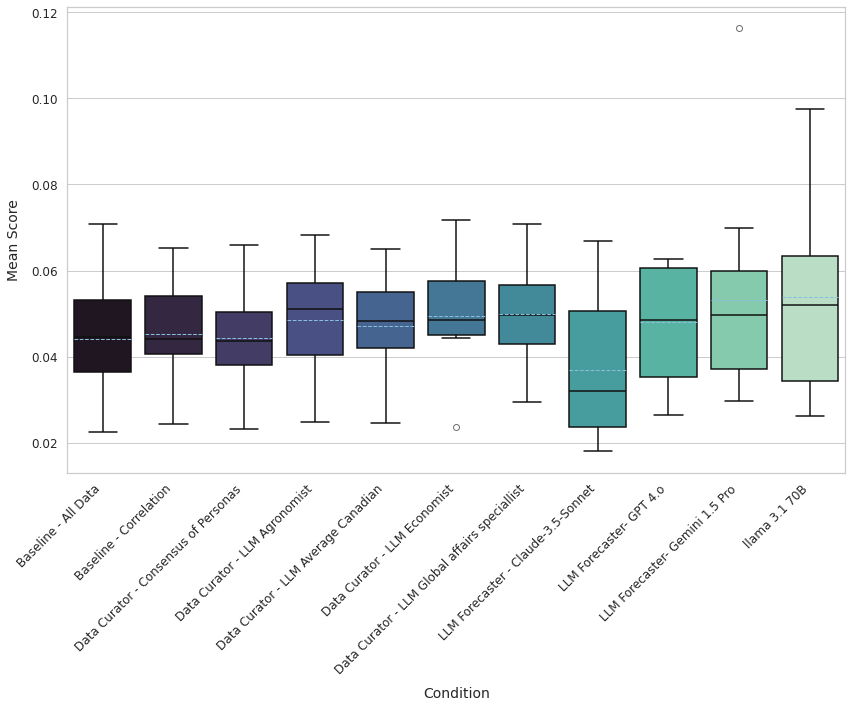

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt
# Set Seaborn style
sns.set_theme(style="whitegrid", palette="Blues")

palette = sns.color_palette("mako", n_colors=filt_df['condition'].nunique())


# Create a boxplot with customized settings
plt.figure(figsize=(12, 10))
sns.boxplot(
    data=filt_df, 
    x='condition', 
    y='mean_score', 
    showmeans=True, 
    meanline=True, 
    linewidth=1.5,
    flierprops={'marker': 'o', 'color': 'lightblue', 'alpha': 0.6},
    palette=palette  # Apply the customized color palette
)

# Customize fonts and angles with adjustments for proper alignment
# plt.title("Model performance comparison for different LLM use-cases - Averaged across 3 food categories and model types", fontsize=18, pad=20)
plt.xlabel("Condition", fontsize=14, labelpad=10)
plt.ylabel("Mean Score", fontsize=14, labelpad=10)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.yticks(fontsize=12)

# Adjust layout for better alignment and appearance
plt.tight_layout()
plt.savefig('./Figure62.pdf')
plt.show()



In [36]:
summary_pivot = filt_df.groupby('model_name').agg(
    Mean=('mean_score', 'mean'),
    Median=('mean_score', 'median'),
    Std_Dev=('mean_score', 'std'),
    Min=('mean_score', 'min'),
    Max=('mean_score', 'max'),
    Count=('mean_score', 'count')
).reset_index()

# Display the pivot table
summary_pivot

,model_name,Mean,Median,Std_Dev,Min,Max,Count
0,SimpleFeedForward,0.05267,0.054059,0.011298,0.030269,0.071837,36
1,TemporalFusionTransformer,0.04017,0.040656,0.010541,0.023078,0.059826,48


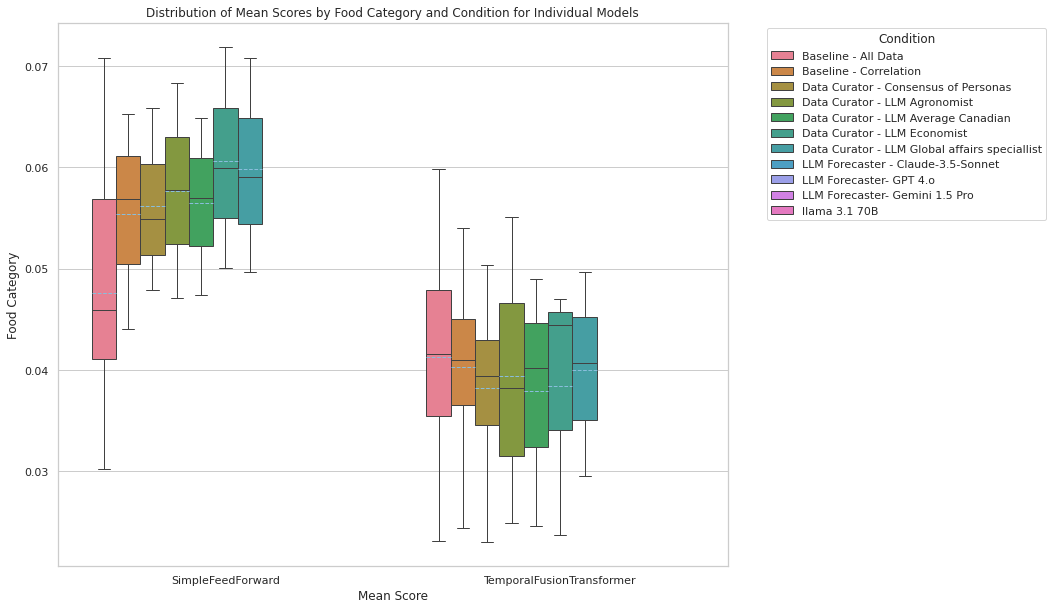

In [37]:

# Set up the plot with category on the y-axis, mean_score on the x-axis, and hue for conditions
plt.figure(figsize=(12, 10))
sns.boxplot(data=filt_df, y='mean_score', x='model_name', hue='condition', showmeans=True, meanline=True)

# Add plot labels and title
plt.title("Distribution of Mean Scores by Food Category and Condition for Individual Models")
plt.xlabel("Mean Score")
plt.ylabel("Food Category")

# Show plot with legend outside
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [38]:
summary_pivot = filt_df.groupby('condition').agg(
    Mean=('mean_score', 'mean'),
    Median=('mean_score', 'median'),
    Std_Dev=('mean_score', 'std'),
    Min=('mean_score', 'min'),
    Max=('mean_score', 'max'),
    Count=('mean_score', 'count')
).reset_index()

# Display the pivot table
summary_pivot

,condition,Mean,Median,Std_Dev,Min,Max,Count
0,Baseline - All Data,0.044149,0.044529,0.011870,0.022539,0.070767,48
1,Baseline - Correlation,0.045339,0.044078,0.012184,0.024436,0.065266,9
2,Data Curator - Consensus of Personas,0.044214,0.043625,0.012483,0.023078,0.065877,9
3,Data Curator - LLM Agronomist,0.048544,0.051086,0.015409,0.024875,0.068291,6
4,Data Curator - LLM Average Canadian,0.047203,0.048229,0.013928,0.024635,0.064906,6
5,Data Curator - LLM Economist,0.049512,0.048552,0.016152,0.023737,0.071837,6
6,Data Curator - LLM Global affairs speciallist,0.049908,0.049699,0.014281,0.029515,0.070762,6
7,LLM Forecaster - Claude-3.5-Sonnet,0.036982,0.032016,0.017088,0.017961,0.066748,12
8,LLM Forecaster- GPT 4.o,0.047991,0.048480,0.013055,0.026463,0.062755,12
9,LLM Forecaster- Gemini 1.5 Pro,0.053242,0.049630,0.023773,0.029670,0.116357,12


### Multiple models

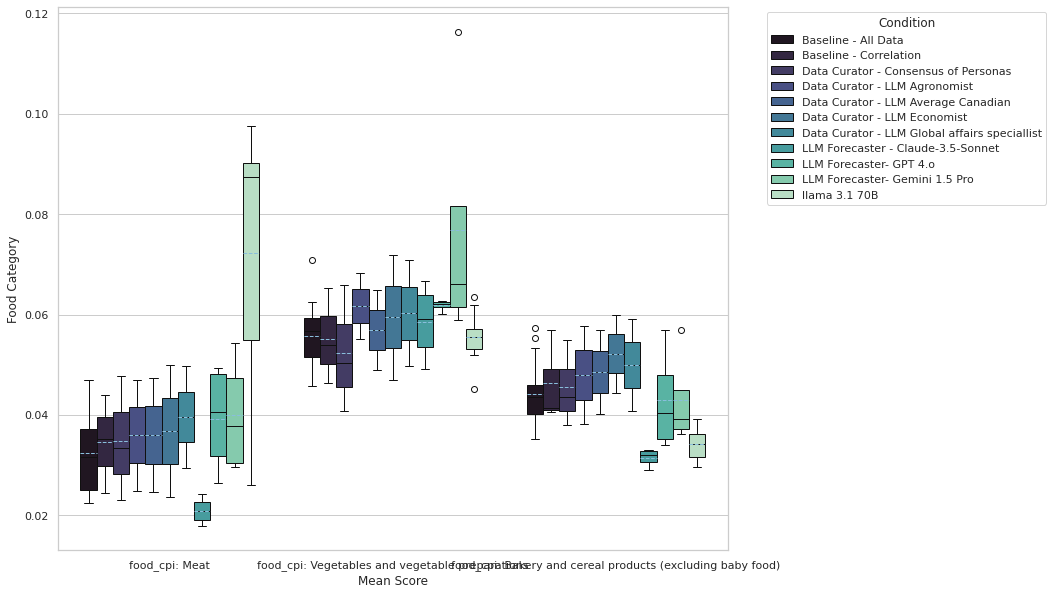

In [39]:

# Set up the plot with category on the y-axis, mean_score on the x-axis, and hue for conditions
plt.figure(figsize=(12, 10))
palette = sns.color_palette("mako", n_colors=filt_df['condition'].nunique())

sns.boxplot(data=filt_df, y='mean_score', x='category', hue='condition', showmeans=True, meanline=True,     palette=palette  # Apply the customized color palette
)



# Add plot labels and title
plt.xlabel("Mean Score")
plt.ylabel("Food Category")

# Show plot with legend outside
plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

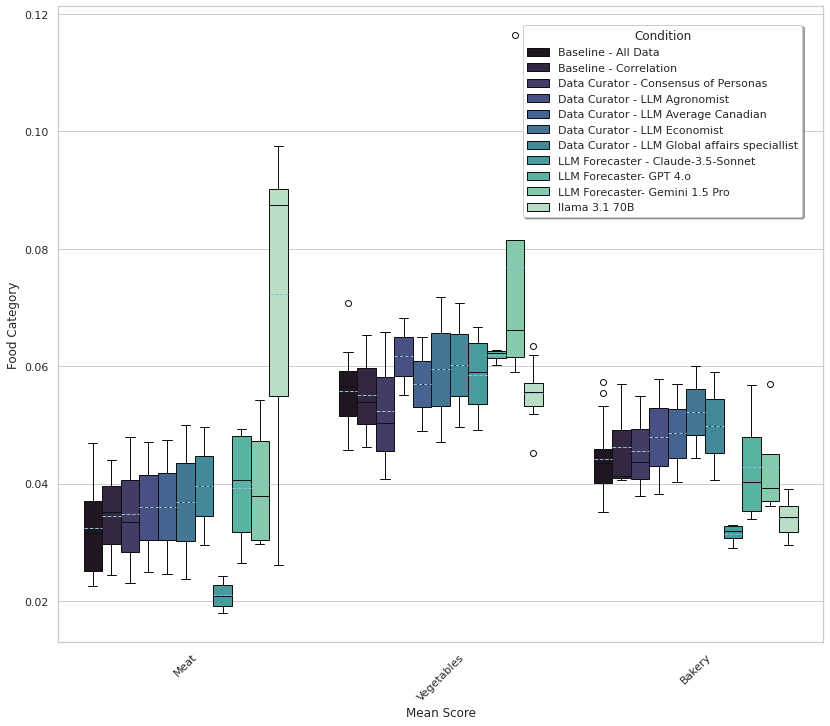

In [40]:
# Extract the first word after the "food_cpi:" prefix and create a new column
filt_df['simple_category'] = filt_df['category'].str.extract(r'food_cpi:\s*(\w+)')[0]

# Set up the plot with the simplified categories on the x-axis
plt.figure(figsize=(12, 10))
palette = sns.color_palette("mako", n_colors=filt_df['condition'].nunique())

sns.boxplot(
    data=filt_df, 
    y='mean_score', 
    x='simple_category',  # Use the simplified categories here
    hue='condition', 
    showmeans=True, 
    meanline=True, 
    palette=palette
)

# Add plot labels and title
plt.xlabel("Mean Score")
plt.ylabel("Food Category")

# Move legend outside and adjust layout
plt.legend(title='Condition', loc='upper right', bbox_to_anchor=(0.98, 0.98), fancybox=True, shadow=True)
plt.tight_layout(pad=2)  # Add padding around plot
plt.xticks(rotation=45)  # Rotate x labels if needed for readability
plt.savefig('./Figure63.pdf')
plt.show()

In [41]:
# Step 1: Aggregate mean and standard deviation
summary_table = filt_df.groupby(['category', 'condition']).agg(
    Mean_Score=('mean_score', 'mean'),
    Std_Deviation=('mean_score', 'std')
).reset_index()

# Step 2: Format the results as "mean ± std"
summary_table['Mean_Std'] = summary_table.apply(
    lambda row: f"{row['Mean_Score']:.3f} ± {row['Std_Deviation']:.3f}", axis=1
)

# Step 3: Pivot the table to have each condition as a column
pivot_table = summary_table.pivot(index='category', columns='condition', values='Mean_Std').reset_index()

# Display the pivoted summary table
pivot_table.set_index('category')

condition,Baseline - All Data,Baseline - Correlation,Data Curator - Consensus of Personas,Data Curator - LLM Agronomist,Data Curator - LLM Average Canadian,Data Curator - LLM Economist,Data Curator - LLM Global affairs speciallist,LLM Forecaster - Claude-3.5-Sonnet,LLM Forecaster- GPT 4.o,LLM Forecaster- Gemini 1.5 Pro,llama 3.1 70B
category,,,,,,,,,,,
food_cpi: Bakery and cereal products (excluding baby food),0.044 ± 0.006,0.046 ± 0.009,0.045 ± 0.009,0.048 ± 0.014,0.049 ± 0.012,0.052 ± 0.011,0.050 ± 0.013,0.031 ± 0.002,0.043 ± 0.010,0.043 ± 0.010,0.034 ± 0.003
food_cpi: Meat,0.032 ± 0.008,0.035 ± 0.010,0.035 ± 0.012,0.036 ± 0.016,0.036 ± 0.016,0.037 ± 0.019,0.040 ± 0.014,0.021 ± 0.003,0.039 ± 0.011,0.040 ± 0.012,0.072 ± 0.028
food_cpi: Vegetables and vegetable preparations,0.056 ± 0.006,0.055 ± 0.010,0.052 ± 0.013,0.062 ± 0.009,0.057 ± 0.011,0.059 ± 0.018,0.060 ± 0.015,0.058 ± 0.008,0.062 ± 0.001,0.077 ± 0.027,0.055 ± 0.005


In [42]:
#Add an overall column 
# Step 1: Format the results as "mean ± std"
summary_pivot['Mean_Std'] = summary_pivot.apply(
    lambda row: f"{row['Mean']:.3f} ± {row['Std_Dev']:.3f}", axis=1)


overall_row = summary_pivot.set_index('condition')['Mean_Std'].T
overall_row

# Step 2: Convert the transposed row to a DataFrame and add 'Overall' label for the category
overall_row = pd.DataFrame(overall_row).T
overall_row['category'] = 'Overall'

#Append 'Overall' row to pivot_table
pivot_table = pd.concat([pivot_table, overall_row], ignore_index=True)

pivot_table.set_index('category')


condition,Baseline - All Data,Baseline - Correlation,Data Curator - Consensus of Personas,Data Curator - LLM Agronomist,Data Curator - LLM Average Canadian,Data Curator - LLM Economist,Data Curator - LLM Global affairs speciallist,LLM Forecaster - Claude-3.5-Sonnet,LLM Forecaster- GPT 4.o,LLM Forecaster- Gemini 1.5 Pro,llama 3.1 70B
category,,,,,,,,,,,
food_cpi: Bakery and cereal products (excluding baby food),0.044 ± 0.006,0.046 ± 0.009,0.045 ± 0.009,0.048 ± 0.014,0.049 ± 0.012,0.052 ± 0.011,0.050 ± 0.013,0.031 ± 0.002,0.043 ± 0.010,0.043 ± 0.010,0.034 ± 0.003
food_cpi: Meat,0.032 ± 0.008,0.035 ± 0.010,0.035 ± 0.012,0.036 ± 0.016,0.036 ± 0.016,0.037 ± 0.019,0.040 ± 0.014,0.021 ± 0.003,0.039 ± 0.011,0.040 ± 0.012,0.072 ± 0.028
food_cpi: Vegetables and vegetable preparations,0.056 ± 0.006,0.055 ± 0.010,0.052 ± 0.013,0.062 ± 0.009,0.057 ± 0.011,0.059 ± 0.018,0.060 ± 0.015,0.058 ± 0.008,0.062 ± 0.001,0.077 ± 0.027,0.055 ± 0.005
Overall,0.044 ± 0.012,0.045 ± 0.012,0.044 ± 0.012,0.049 ± 0.015,0.047 ± 0.014,0.050 ± 0.016,0.050 ± 0.014,0.037 ± 0.017,0.048 ± 0.013,0.053 ± 0.024,0.054 ± 0.023


### Single model - TemporalFusionTransformer

In [43]:
'''
Here there are:
-no standard deviations for none b/c 
-standard deviations for regressors are mix of w/ covariates 
'''



# Step 1: Aggregate mean and standard deviation
summary_table = filt_df.groupby(['category', 'condition']).agg(
    Mean_Score=('mean_score', 'mean'),
    Std_Deviation=('mean_score', 'std')
).reset_index()

# Step 2: Format the results as "mean ± std"
summary_table['Mean_Std'] = summary_table.apply(
    lambda row: f"{row['Mean_Score']:.4f} ± {row['Std_Deviation']:.4f}", axis=1
)


# Step 3: Pivot the table to have each condition as a column
pivot_table = summary_table.pivot(index='category', columns='condition', values='Mean_Std').reset_index()

# Display the pivoted table
pivot_table

condition,category,Baseline - All Data,Baseline - Correlation,Data Curator - Consensus of Personas,Data Curator - LLM Agronomist,Data Curator - LLM Average Canadian,Data Curator - LLM Economist,Data Curator - LLM Global affairs speciallist,LLM Forecaster - Claude-3.5-Sonnet,LLM Forecaster- GPT 4.o,LLM Forecaster- Gemini 1.5 Pro,llama 3.1 70B
0,food_cpi: Bakery and cereal products (excludin...,0.0442 ± 0.0064,0.0463 ± 0.0092,0.0455 ± 0.0086,0.0480 ± 0.0138,0.0486 ± 0.0118,0.0522 ± 0.0110,0.0499 ± 0.0130,0.0315 ± 0.0018,0.0429 ± 0.0105,0.0429 ± 0.0096,0.0342 ± 0.0032
1,food_cpi: Meat,0.0324 ± 0.0082,0.0346 ± 0.0098,0.0348 ± 0.0124,0.0360 ± 0.0157,0.0360 ± 0.0161,0.0369 ± 0.0186,0.0396 ± 0.0143,0.0210 ± 0.0028,0.0393 ± 0.0111,0.0399 ± 0.0119,0.0723 ± 0.0282
2,food_cpi: Vegetables and vegetable preparations,0.0558 ± 0.0064,0.0552 ± 0.0095,0.0524 ± 0.0126,0.0617 ± 0.0093,0.0570 ± 0.0112,0.0594 ± 0.0175,0.0602 ± 0.0149,0.0585 ± 0.0079,0.0618 ± 0.0012,0.0769 ± 0.0267,0.0554 ± 0.0050


In [44]:
'''
Here there are:
-no standard deviations for none b/c 
-standard deviations for regressors are mix of w/ covariates 
'''

# Step 2: Format the results as "mean ± std"
filt_df['Mean_Std'] = filt_df.apply(
    lambda row: f"{row['mean_score']:.3f} ± {row['std_score']:.3f}", axis=1
)


# Step 3: Pivot the table to have each condition as a column
pivot_table = filt_df.pivot(index='category', columns='condition', values='Mean_Std').reset_index()

# Display the pivoted table
pivot_table

ValueError: Index contains duplicate entries, cannot reshape

In [ ]:
# Step 1: Format the results as "mean ± std"
summary_pivot['Mean_Std'] = summary_pivot.apply(
    lambda row: f"{row['Mean']:.3f} ± {row['Std_Dev']:.3f}", axis=1)


overall_row = summary_pivot.set_index('condition')['Mean_Std'].T
overall_row

# Step 2: Convert the transposed row to a DataFrame and add 'Overall' label for the category
overall_row = pd.DataFrame(overall_row).T
overall_row['category'] = 'Overall'

#Append 'Overall' row to pivot_table
pivot_table = pd.concat([pivot_table, overall_row], ignore_index=True)

pivot_table.set_index('category')


In [ ]:

# # Step 1: Create a bar plot with error bars to reflect std deviation
# plt.figure(figsize=(12, 8))
# sns.barplot(data=filt_df, x='category', y='mean_score', hue='condition', ci=None)

# # Step 2: Add error bars manually for std deviation
# for index, row in filt_df.iterrows():
#     category_index = filt_df['category'].tolist().index(row['category'])
#     condition_offset = {'all': -0.3, 'climate': -0.15, 'geopolitical': 0, 'manufacturing': 0.15, 'none': 0.3}  # Offset to separate conditions
#     plt.errorbar(
#         x=category_index + condition_offset[row['condition']], 
#         y=row['mean_score'],
#         yerr=row['std_score'],
#         fmt='none',  # No plot marker, only error bars
#         color='black',  # Error bar color
#         capsize=5  # Cap width
#     )

# # Customize plot labels and legend
# plt.title("Mean Scores by Food Category with Standard Deviation as Error Bars")
# plt.xlabel("Food Category")
# plt.ylabel("Mean Score")
# plt.xticks(rotation=45)
# plt.legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')

# # Show plot
# plt.show()